In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
X = np.array([
[[1, 1, 1], [1, 0, 1], [1, 0, 1], [1, 0, 1], [1, 1, 1]],
[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]],
[[1, 1, 1], [0, 0, 1], [1, 1, 1], [1, 0, 0], [1, 1, 1]],
[[1, 1, 1], [0, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 1]],
[[1, 0, 1], [1, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1]],
[[1, 0, 1], [1, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1]],
[[1, 1, 1], [1, 0, 0], [1, 1, 1], [0, 0, 1], [1, 1, 1]],
[[1, 1, 1], [1, 0, 0], [1, 1, 1], [1, 0, 1], [1, 1, 1]],
[[1, 1, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]],
[[1, 1, 1], [1, 0, 1], [1, 1, 1], [1, 0, 1], [1, 1, 1]],
[[1, 1, 1], [1, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 1]]]).reshape(11, -1)

y = pd.get_dummies(pd.DataFrame({"y": ["0", "1", "2", "3", "4", "4", "5", "6", "7", "8", "9"]}), drop_first = False).values.astype("int8")

In [3]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (10), activation = "relu", random_state = 42, max_iter = 5000)

model.fit(X, y)

MLPClassifier(hidden_layer_sizes=10, max_iter=5000, random_state=42)

In [4]:
model.predict(X)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [40]:
class VectorizedEvoClassifierM01:
    def __init__(self, n = 20, hidden_layers = False, activation = "relu", random_state = None):

        self.n = n // 2 * 2
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.number_of_layers = 0
        
        if hidden_layers:
            self.layers = hidden_layers + [10]
        else:
            self.layers = [10]

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        if self.random_state != None:
            np.random.seed(self.random_state)

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        #output_activation_function = lambda x: 1 / (1 + np.exp(-x))
        output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 2, keepdims = True)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]
        y_train = y_train.astype("int8")

        n = self.n
        layers = [X_train.shape[1]] + self.layers
        number_of_layers_minus_one = len(layers) - 1
        y_preds = np.zeros((n, y_train.shape[0], y_train.shape[1]))
        nets_loss = np.zeros(n)
        sorted_indices = np.arange(-(n // 2), n, 1)
        #sorted_indices = np.zeros(n)
        best_net_index = -1
        weights = []

        for i in range(number_of_layers_minus_one):
            weights += [np.random.normal(0, 1, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(number_of_layers_minus_one - 1):
                forward_pass = activation_function(weights[j][sorted_indices[n // 2:]].transpose(0, 2, 1) @ forward_pass)
            
            forward_pass = weights[-1][sorted_indices[n // 2:]].transpose(0, 2, 1) @ forward_pass
            
            y_preds[sorted_indices[n // 2:]] = output_activation_function(forward_pass.transpose(0, 2, 1))

            nets_loss[sorted_indices[n // 2:]] = np.mean(np.sum(-y_train * np.log10(y_preds[sorted_indices[n // 2:]]), axis = 2), axis = 1)

            sorted_indices = np.argsort(nets_loss)

            mutation_sigma = 0.08 + 0.5 * 1 / math.exp(epoch / ((epochs + 1) / (60 * math.log10(epochs + 1))))

            for j in range(number_of_layers_minus_one):
                weights[j][sorted_indices[n // 2::2]] = (weights[j][sorted_indices[:n // 2:2]] + weights[j][sorted_indices[1:1 + n // 2:2]]) / 2 + np.random.normal(0, mutation_sigma, (n // 4, layers[j], layers[j + 1]))
                weights[j][sorted_indices[1 + n // 2::2]] = (weights[j][sorted_indices[:n // 2:2]] + weights[j][sorted_indices[1:1 + n // 2:2]]) / 2 + np.random.normal(0, mutation_sigma, (n // 4, layers[j], layers[j + 1]))

            if best_net_index != sorted_indices[0]:
                best_net_index = sorted_indices[0]
                self.training_loss_history += [nets_loss[best_net_index]]
                

                self.best_net_weights = []
                for j in range(number_of_layers_minus_one):
                    self.best_net_weights += [weights[j][best_net_index]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - {mutation_sigma}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        #output_activation_function = lambda x: 1 / (1 + np.exp(-x))
        output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)

        forward_pass = X.T
        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)

        forward_pass = self.best_net_weights[-1].T @ forward_pass
        
        return output_activation_function(forward_pass.T)


In [124]:
import line_profiler

In [125]:
%load_ext line_profiler

In [127]:
%reload_ext line_profiler

import math

class VectorizedEvoClassifierM:
    def __init__(self, n = 24, hidden_layers = False, activation = "relu", lr_target = 0.04, lr_initial_decay = 60, lr_final_decay = 0.03, random_state = None):

        self.n = int(round(n / 8) * 8)
        self.validation_loss_history = []
        self.training_loss_history = []
        self.random_state = random_state
        self.activation = activation
        self.lr_target = lr_target
        self.lr_initial_decay = lr_initial_decay
        self.lr_final_decay = lr_final_decay

        
        if hidden_layers:
            self.hidden_layers = hidden_layers
        else:
            self.hidden_layers = False

        

    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):

        n = self.n
        ndiv4 = n // 4

        if self.random_state != None:
            np.random.seed(self.random_state)

        X_train = np.c_[np.ones(X_train.shape[0]), X_train]
        y_train = y_train.astype("int8")

        if len(y_train.shape) == 1:
            self.multiclass = False
        elif len(y_train.shape) == 2 and y_train.shape[1] == 1:
            self.multiclass = False
            y_train = y_train.ravel()
        else:
            self.multiclass = True
            

        if validation_data:
            X_val, y_val = validation_data

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 2, keepdims = True)
            
            def loss_function(y_train, y_preds, sorted_indices):
                return np.mean(np.sum(-y_train * np.log10(y_preds[sorted_indices[ndiv4:]]), axis = 2), axis = 1)

        elif self.multiclass == False:
            output_activation_function = lambda x: 1 / (1 + np.exp(-x))

            def loss_function(y_train, y_preds, sorted_indices):
                return np.mean(np.abs(y_preds[sorted_indices[ndiv4:]] - y_train), axis = 1)

        lr_target = self.lr_target
        lr_initial_decay = self.lr_initial_decay
        lr_final_decay = self.lr_final_decay

        layers = [X_train.shape[1]]

        if self.hidden_layers:
            layers = [X_train.shape[1]] + self.hidden_layers

        if self.multiclass == True:
            layers = layers + [y_train.shape[1]]
        elif self.multiclass == False:
            layers = layers + [1]

        number_of_layers_minus_one = len(layers) - 1
        
        if self.multiclass == True:
            y_preds = np.zeros((n, y_train.shape[0], y_train.shape[1]))
        elif self.multiclass == False:
            y_preds = np.zeros((n, y_train.shape[0]))

        nets_loss = np.zeros(n)
        sorted_indices = np.arange(-(ndiv4), n, 1)

        best_net_index = -1

        weights = []

        for i in range(number_of_layers_minus_one):
            weights += [np.random.normal(0, 1, (n, layers[i], layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(number_of_layers_minus_one - 1):
                forward_pass = activation_function(weights[j][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass)
            
            forward_pass = weights[-1][sorted_indices[ndiv4:]].transpose(0, 2, 1) @ forward_pass
            
            y_preds[sorted_indices[ndiv4:]] = output_activation_function(forward_pass.transpose(0, 2, 1))

            nets_loss[sorted_indices[ndiv4:]] = loss_function(y_train, y_preds, sorted_indices)

            sorted_indices = np.argsort(nets_loss)
            mutation_sigma = math.exp(-epoch / (epochs / (lr_initial_decay * math.log10(epochs + 1)))) + lr_final_decay * math.exp(-(epoch + 1) * (1 / (epochs))) + lr_target + (-0.036 * 10 * lr_final_decay)
            #mutation_sigma = math.exp(-epoch / (epochs / (lr_initial_decay * math.log10(epochs + 1)))) + 0.08 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) + 0.02
            #mutation_sigma = math.exp(-epoch / (epochs / (lr_decay * math.log10(epochs + 1)))) + 0.02 * math.exp(-(epoch + 1) * (1 / (epochs + 1))) - 0.005
            #mutation_sigma = 0.08 + 0.5 * 1 / math.exp(epoch / ((epochs + 1) / (60 * math.log10(epochs + 1))))

            for j in range(number_of_layers_minus_one):
                weights[j][sorted_indices[0 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[1 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[2 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[3 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[4 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))
                weights[j][sorted_indices[5 + ndiv4::6]] = (weights[j][sorted_indices[0: ndiv4: 2]] + weights[j][sorted_indices[1: ndiv4: 2]]) / 2 + np.random.normal(0, mutation_sigma, (ndiv4 // 2, layers[j], layers[j + 1]))

            if best_net_index != sorted_indices[0]:
                best_net_index = sorted_indices[0]
                self.training_loss_history += [nets_loss[best_net_index]]
                

                self.best_net_weights = []
                for j in range(number_of_layers_minus_one):
                    self.best_net_weights += [weights[j][best_net_index]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - {mutation_sigma}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        if self.activation == "sigmoid":
            activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif self.activation == "leaky_relu":
            activation_function = lambda x: np.maximum(0.1 * x, x)
        else:
            activation_function = lambda x: np.maximum(0, x)

        if self.multiclass == True:
            output_activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)
        elif self.multiclass == False:
            output_activation_function = lambda x: 1 / (1 + np.exp(-x))

        forward_pass = X.T
        for j in range(len(self.best_net_weights) - 1):
            forward_pass = activation_function(self.best_net_weights[j].T @ forward_pass)

        forward_pass = self.best_net_weights[-1].T @ forward_pass
        
        return output_activation_function(forward_pass.T)

evomodel = VectorizedEvoClassifierM(n = 24 * 4, hidden_layers = [10], lr_target = 0.1, lr_initial_decay = 60, lr_final_decay = 0.3, random_state = 42)
%lprun -f evomodel.fit evomodel.fit(X, y, epochs = 10000, verbose = 1)

Epoch 0 - loss: 0.9998311820346312 - 1.29197000149995
Epoch 7 - loss: 0.9493318441214512 - 1.137112388781039
Epoch 8 - loss: 0.945449826545742 - 1.1170352695971997
Epoch 10 - loss: 0.9084038714228551 - 1.0782959928363374
Epoch 11 - loss: 0.7883575093520281 - 1.0596115544075175
Epoch 18 - loss: 0.7825842323168328 - 0.9406368729628037
Epoch 21 - loss: 0.7821526861229309 - 0.8954468027447978
Epoch 23 - loss: 0.772074035496816 - 0.8670744764788247
Epoch 26 - loss: 0.6475596629216347 - 0.826984420356625
Epoch 28 - loss: 0.6458369904993683 - 0.8018137178058867
Epoch 30 - loss: 0.5164098736104002 - 0.7778198910879496
Epoch 39 - loss: 0.5056881722204376 - 0.6829918872536017
Epoch 42 - loss: 0.5033540862274465 - 0.6556569221318098
Epoch 45 - loss: 0.4994401150710219 - 0.6302147129256686
Epoch 49 - loss: 0.497508282466169 - 0.5990101199070317
Epoch 50 - loss: 0.47200657881450925 - 0.5916641828003322
Epoch 61 - loss: 0.4538528599723891 - 0.5214512626607359
Epoch 66 - loss: 0.4489289979809142 - 0.

Timer unit: 1e-06 s

Total time: 6.12531 s
File: /var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_82011/3315824649.py
Function: fit at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                               def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
    26                                           
    27         1          1.0      1.0      0.0          n = self.n
    28         1          1.0      1.0      0.0          ndiv4 = n // 4
    29                                           
    30         1          1.0      1.0      0.0          if self.random_state != None:
    31         1          9.0      9.0      0.0              np.random.seed(self.random_state)
    32                                           
    33         1       1852.0   1852.0      0.0          X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    34         1          9.0      9.0      0.0          y_train

In [123]:
evomodel = VectorizedEvoClassifierM(n = 24 * 4, hidden_layers = [10], lr_target = 0.1, lr_initial_decay = 60, lr_final_decay = 0.3, random_state = 42)
evomodel.fit(X, y, epochs = 10000, verbose = 1)

Epoch 0 - loss: 0.9998311820346312 - 1.29197000149995
Epoch 7 - loss: 0.9493318441214512 - 1.137112388781039
Epoch 8 - loss: 0.945449826545742 - 1.1170352695971997
Epoch 10 - loss: 0.9084038714228551 - 1.0782959928363374
Epoch 11 - loss: 0.7883575093520281 - 1.0596115544075175
Epoch 18 - loss: 0.7825842323168328 - 0.9406368729628037
Epoch 21 - loss: 0.7821526861229309 - 0.8954468027447978
Epoch 23 - loss: 0.772074035496816 - 0.8670744764788247
Epoch 26 - loss: 0.6475596629216347 - 0.826984420356625
Epoch 28 - loss: 0.6458369904993683 - 0.8018137178058867
Epoch 30 - loss: 0.5164098736104002 - 0.7778198910879496
Epoch 39 - loss: 0.5056881722204376 - 0.6829918872536017
Epoch 42 - loss: 0.5033540862274465 - 0.6556569221318098
Epoch 45 - loss: 0.4994401150710219 - 0.6302147129256686
Epoch 49 - loss: 0.497508282466169 - 0.5990101199070317
Epoch 50 - loss: 0.47200657881450925 - 0.5916641828003322
Epoch 61 - loss: 0.4538528599723891 - 0.5214512626607359
Epoch 66 - loss: 0.4489289979809142 - 0.

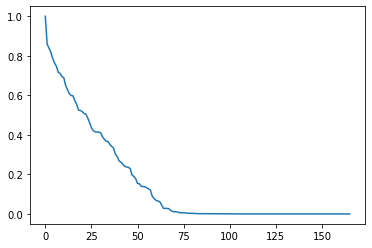

In [120]:
fig, ax = plt.subplots(1, 1)

ax.plot(evomodel.training_loss_history)
plt.show()

In [97]:
evomodel = VectorizedEvoClassifierM01(n = 48, hidden_layers = [10], random_state = 42)
evomodel.fit(X, y, epochs = 100, verbose = 1)

Epoch 0 - loss: 1.1082605459524975 - 0.58
Epoch 2 - loss: 0.9543084041914337 - 0.12621184586265957
Epoch 3 - loss: 0.9359153862388222 - 0.09404898574986237
Epoch 4 - loss: 0.9268551659953826 - 0.08427106939606842
Epoch 5 - loss: 0.9114848113842181 - 0.08129845912799868
Epoch 6 - loss: 0.909553585999841 - 0.08039474800119967
Epoch 7 - loss: 0.8952747188709296 - 0.08012000838616408
Epoch 8 - loss: 0.8915235571537253 - 0.08003648406757206
Epoch 9 - loss: 0.8545270712003362 - 0.08001109161808728
Epoch 10 - loss: 0.8381145037108438 - 0.08000337199221416
Epoch 12 - loss: 0.8112831889965421 - 0.0800003116519689
Epoch 13 - loss: 0.7953168669221099 - 0.08000009474614113
Epoch 14 - loss: 0.7923423801548026 - 0.0800000288040255
Epoch 15 - loss: 0.7862474367635817 - 0.08000000875678814
Epoch 17 - loss: 0.7696366769355939 - 0.08000000080933468
Epoch 18 - loss: 0.7672391522298984 - 0.08000000024604799
Epoch 20 - loss: 0.7523209175194037 - 0.08000000002274066
Epoch 21 - loss: 0.7466652546095311 - 0.0

In [118]:
y_pred = evomodel.predict(X)

(y_pred > 0.5) * 1

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [115]:


a = np.array([
    [[15.48941891, -2.09846987, -8.58431883, 0.92524371, 4.67316101, 15.6263859, 12.23011818, 10.22337356, -5.97467029, 0.7186], 
    [-1.67894923, 4.82557838, -4.92448585, 1.07249996, -4.52925044, 20.74225489, 6.74903597, 15.98542702, -3.82235716, 1.74474188]],
    
    [[15.48941891, -2.09846987, -8.58431883, 0.92524371, 4.67316101, 15.6263859, 12.23011818, 10.22337356, -5.97467029, 0.7186], 
    [-1.67894923, 4.82557838, -4.92448585, 1.07249996, -4.52925044, 20.74225489, 6.74903597, 15.98542702, -3.82235716, 1.74474188]]
])

a.shape

(2, 2, 10)

In [175]:
activation_function = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 2, keepdims = True)

test = lambda x: np.sum(np.exp(x), axis = 2)

b = activation_function(a)
b

bt = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [178]:
np.mean(np.sum(-bt * np.log10(b), axis = 2), axis = 1)

array([5.04082153, 5.04082153])